<a href="https://colab.research.google.com/github/dercodeKoenig/colab-KI/blob/main/cyforecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%writefile kaggle.json
{"username":"rammellutz","key":"bc9c85fb114c7ca4f3f046207998604c"}

Writing kaggle.json


In [2]:
from IPython.display import clear_output
import numpy as np
import tensorflow as tf
import copy
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [3]:
!mkdir /root/.kaggle
!mv kaggle.json /root/.kaggle/kaggle.json
!kaggle datasets download -d bpwqsdd/ethusdt01012018
!unzip ethusdt01012018.zip
!mkdir input
!mv *.npy input/
clear_output()

In [24]:
seq_len = int(24*3*60)
batch_size = 20
learnrate = 0.0001
looks_in_future = 50

datadir = "input/"

valid_symbols = ['ETHUSDT', 'AAVEUSDT', 'ADAUSDT', 'ADXUSDT', 'AIONUSDT', 'AVAXUSDT', 'AXSUSDT', 'BATUSDT', 'BLZUSDT', 'BNBUSDT', 'BNTUSDT', 'CHRUSDT', 'CVCUSDT', 'DASHUSDT', 'DATAUSDT', 'DENTUSDT', 'DEXEUSDT', 'DOTUSDT', 'ELFUSDT', 'ENJUSDT', 'EOSUSDT', 'ETCUSDT', 'FIROUSDT', 'FTMUSDT', 'FUNUSDT', 'GALAUSDT', 'GHSTUSDT', 'GRTUSDT', 'GXSUSDT', 'HOTUSDT', 'ICXUSDT', 'IOSTUSDT', 'IOTAUSDT', 'IOTXUSDT', 'KEYUSDT', 'KMDUSDT', 'KNCUSDT', 'LINKUSDT', 'LRCUSDT', 'LSKUSDT', 'LTCUSDT', 'MANAUSDT', 'MATICUSDT', 'MFTUSDT', 'MTLUSDT', 'NANOUSDT', 'NEOUSDT', 'OMGUSDT', 'ONTUSDT', 'POWRUSDT', 'PUNDIXUSDT', 'REPUSDT', 'RLCUSDT', 'SANDUSDT', 'SCUSDT', 'SOLUSDT', 'STRAXUSDT', 'THETAUSDT', 'TRXUSDT', 'VETUSDT', 'VGXUSDT', 'WANUSDT', 'WAVESUSDT', 'XEMUSDT', 'XLMUSDT', 'XMRUSDT', 'XRPUSDT', 'XVGUSDT', 'ZECUSDT', 'ZENUSDT', 'ZILUSDT', 'ZRXUSDT']

print(len(valid_symbols),"symbols found")
symbol = valid_symbols[0]
print("woking on", symbol)

72 symbols found
woking on ETHUSDT


In [5]:
npd = np.load(datadir+symbol+".npy",allow_pickle=True)
print("loaded:", npd.shape)

loaded: (2077934, 7)


In [6]:
all_time_high = max(npd,key=lambda x: float(x[3]))
print("all_time_high:",all_time_high[0], "with", all_time_high[3])
all_time_high = float(all_time_high[3])

all_time_high: 10/11/2021 with 4868.00000000


In [7]:
npd_relative = []
print("converting to relative data...")


for i in tqdm(range(npd.shape[0]-1)):
    #changes
    price_open  = (float(npd[i+1][2])-float(npd[i][2]))/float(npd[i][2])
    price_high  = (float(npd[i+1][3])-float(npd[i][3]))/float(npd[i][3])
    price_low   = (float(npd[i+1][4])-float(npd[i][4]))/float(npd[i][4])
    price_close = (float(npd[i+1][5])-float(npd[i][5]))/float(npd[i][5])
    volume = 0
    if float(npd[i][6]) > 0:
        volume = (float(npd[i+1][6])-float(npd[i][6]))/float(npd[i][6])
        
    #max/min price in price / ath
    price_relative_ath_max = float(npd[i+1][3]) / all_time_high
    price_relative_ath_min = float(npd[i+1][4]) / all_time_high
    
    npd_relative.append((price_open, price_high, price_low, price_close, volume, price_relative_ath_max, price_relative_ath_min))
    
npd = np.array(npd_relative,dtype="float32")
print(npd.shape)

converting to relative data...


100%|██████████| 2077933/2077933 [00:29<00:00, 69500.21it/s]

(2077933, 7)


In [8]:
def unpack_batch(batch):
    X=[]
    Y=[]
    for i in batch:
            X.append(i[0])
            Y.append(i[1])
    X = np.array(X,dtype="float32")
    Y = np.array(Y,dtype="float32")
    
    return (X, Y)
          
def array_to_samples(ar):
    samples = []
    l = ar.shape[0]-seq_len-looks_in_future
    
    for i in range(l):
        array_future_data = ar[i+seq_len+1:i+seq_len+1+looks_in_future]
        maxval = np.amax(array_future_data, axis=0)[5]
        minval = np.amin(array_future_data, axis=0)[6]
        
        maxval_relative = (maxval - ar[i+seq_len][5]) /ar[i+seq_len][5]
        minval_relative = (minval - ar[i+seq_len][6]) /ar[i+seq_len][6]
        
        data = (ar[i:i+seq_len],(maxval_relative,minval_relative))
        samples.append(np.array(data,dtype=object))
    
    return np.array(samples,dtype=object)

In [9]:
l_in = tf.keras.layers.Input(shape=(seq_len,7), batch_size=batch_size)
c1 = tf.keras.layers.Conv1D(64,16,activation="relu")(l_in)
c2 = tf.keras.layers.Conv1D(128,8,activation="relu")(c1)
c3 = tf.keras.layers.Conv1D(256,4,activation="relu")(c2)
rn1 = tf.keras.layers.GRU(128, return_sequences=True)(c3)
rn2 = tf.keras.layers.GRU(128, return_sequences=True)(rn1)
rn3 = tf.keras.layers.GRU(128, return_sequences=False)(rn2)
rn3.shape
flat = tf.keras.layers.Flatten()(rn3)
d1 = tf.keras.layers.Dense(256,activation="relu")(flat)
d2 = tf.keras.layers.Dense(128,activation="relu")(d1)
d3 = tf.keras.layers.Dense(64,activation="relu")(d2)
l_out = tf.keras.layers.Dense(2)(d3)

model = tf.keras.Model(l_in, l_out)
#model.summary()

In [10]:
samples_len = npd.shape[0] - seq_len - looks_in_future
batch_num = int(samples_len / batch_size)
print("number of batches:",batch_num)

number of batches: 103678


last loss: 6.8104404e-05


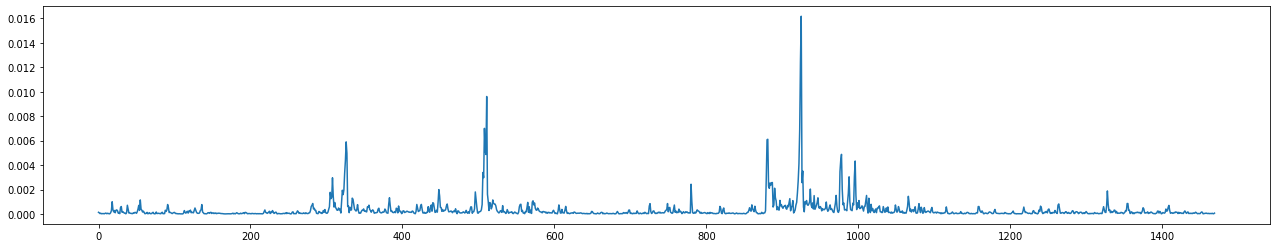

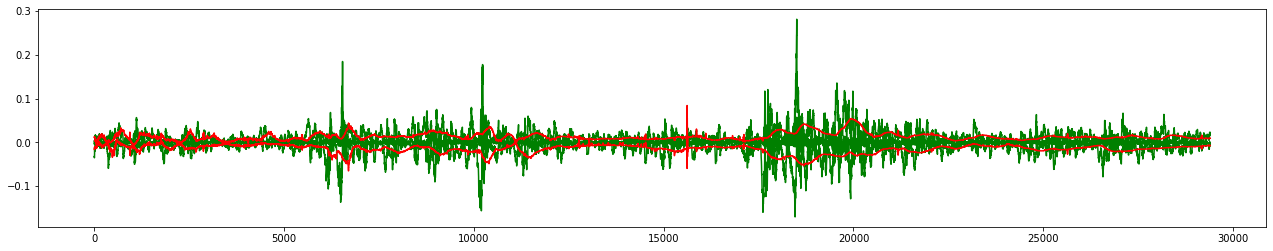

In [ ]:
opt = tf.keras.optimizers.Adam(learnrate)
losses = []
ct = 0

y_true_vals = []
y_output_vals = []

for s in range(batch_num):
    curr_batch = npd[s * batch_size: (s + 1) * batch_size + seq_len + looks_in_future]
    samples = array_to_samples(curr_batch)
    X, Y = unpack_batch(samples)
    with tf.GradientTape() as tape:
        outputs = model(X)
        loss = tf.keras.losses.mse(Y,outputs)
    
    for i in Y:
      y_true_vals.append(i)
    for i in outputs:
      y_output_vals.append(i)
    
    losses.append(np.mean(loss.numpy()))
    gradients = tape.gradient(loss,model.trainable_variables)
    opt.apply_gradients(zip(gradients,model.trainable_variables))
        
    ct+=1
    if(ct%10==0):
        clear_output()
        print("last loss:",losses[-1])
        plt.figure(figsize=(22,4))
        _=plt.plot(losses)
        plt.show()

        plt.figure(figsize=(22,4))
        _=plt.plot(y_true_vals, color = "green")
        _=plt.plot(y_output_vals, color = "red")
        plt.show()

clear_output()

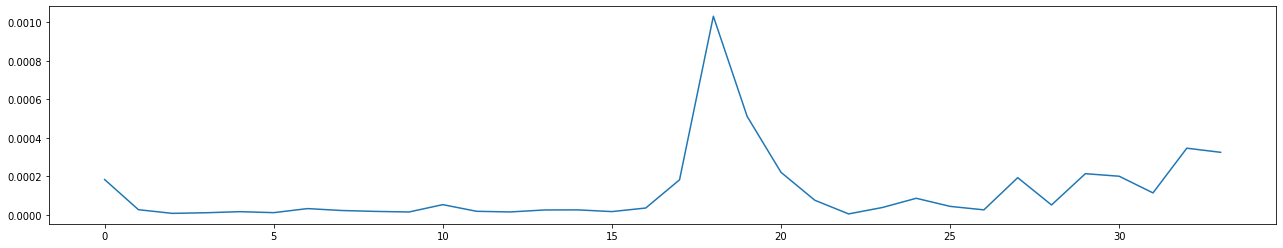

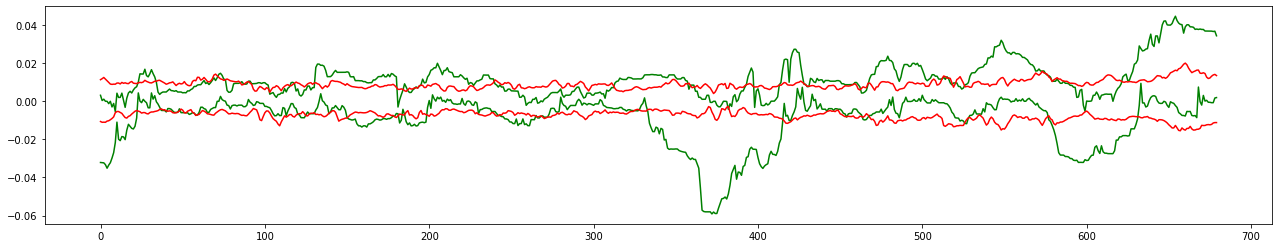

In [25]:
plt.figure(figsize=(22,4))
_=plt.plot(losses)
plt.show()
model.save_weights(symbol)

np.save("y_true_vals",np.array(y_true_vals))
np.save("y_output_vals",np.array(y_output_vals))
np.save("losses",np.array(losses))

plt.figure(figsize=(22,4))
_=plt.plot(y_true_vals, color = "green")
_=plt.plot(y_output_vals, color = "red")
plt.show()